importing Jupyter notebook from metadata_options.ipynb
TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
importing Jupyter notebook from models_nn.ipynb


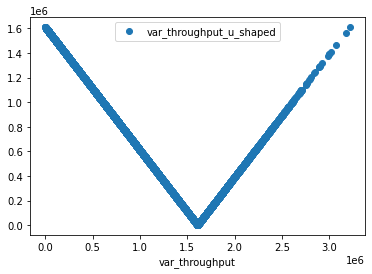

In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report

from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim

from collections import defaultdict

## Own code 
import import_ipynb
import metadata_options
import models_nn
import Text_Huggingface_Transformers

In [ ]:
full_df = pd.read_csv('data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
full_df = full_df.dropna() # dataset contains NaN values, dropping NaNs here

y_variables = ['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label', 
               'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label',
               'Input.deception_quadrant']

In [ ]:
######################################
## Metadata Options ##
######################################

throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 1

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [ ]:
######################################
## Model Options ##
# From 0 to 3
######################################
model_option = 0

pre_trained_model_selection = ['bert-base-uncased', 'distilbert-base-uncased', 
                               'albert-base-v2', 'roberta-base']

PRE_TRAINED_MODEL_NAME = pre_trained_model_selection[model_option]
print(PRE_TRAINED_MODEL_NAME)

epochs = 4

In [ ]:
le = LabelEncoder()
full_df['Answer.1gamemove.yes_label'] = le.fit_transform(full_df['Answer.1gamemove.yes_label'])
full_df['Answer.2reasoning.yes_label'] = le.fit_transform(full_df['Answer.2reasoning.yes_label'])
full_df['Answer.3rapport.yes_label'] = le.fit_transform(full_df['Answer.3rapport.yes_label'])
full_df['Answer.4shareinformation.yes_label'] = le.fit_transform(full_df['Answer.4shareinformation.yes_label'])
full_df['Input.deception_quadrant'] = le.fit_transform(full_df['Input.deception_quadrant'])

df_train, df_test = train_test_split(full_df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.2)

y_train_deception = df_train['Input.deception_quadrant'].tolist()
y_test_deception = df_test['Input.deception_quadrant'].tolist()

y_train_rapport = df_train['Answer.3rapport.yes_label'].tolist()
y_test_rapport = df_test['Answer.3rapport.yes_label'].tolist()

y_test_deception = np.asarray(y_test_deception)
y_train_deception = np.asarray(y_train_deception)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

### Construct individual models

In [ ]:
models_dict = {}
models_train_pred_dict = {}
models_test_pred_dict = {}

for y_var in y_variables:
    print()
    print(y_var)
    
    # Create data splits
    train_data_loader = Text_Huggingface_Transformers.create_data_loader(df_train, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    test_data_loader = Text_Huggingface_Transformers.create_data_loader(df_test, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    val_data_loader = Text_Huggingface_Transformers.create_data_loader(df_val, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    
    # Sainty checks
    print('sanity checks')
    data = next(iter(train_data_loader))
    print(data.keys())
    
    class_names = df_train[y_var].unique()
    
    # Create classifier model
    new_model = Text_Huggingface_Transformers.QuadrantClassifier(len(class_names))
    new_model = new_model.to(device)
    
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)

    nn.functional.softmax(new_model(input_ids, attention_mask), dim=1)

    # Compile model for number of epochs
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(
            new_model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            new_model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
          )

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), y_var + '.bin')
            best_accuracy = val_acc
    
    # Get predictions
    test_acc, _ = eval_model(
      new_model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )
        
    y_full_texts, y_pred_train, y_pred_probs, y_test = Text_Huggingface_Transformers.get_predictions(
      new_model,
      train_data_loader
    )
    y_pred_train = y_pred_train.numpy()
    y_test = y_test.numpy()

    # Classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    print(pd.DataFrame(report).transpose())
    
    y_full_texts, y_pred_test, y_pred_probs, y_test = Text_Huggingface_Transformers.get_predictions(
      new_model,
      test_data_loader
    )
    y_pred_test = y_pred_test.numpy()
    y_test = y_test.numpy()
        
    # Add to model
    model_dict[y_var] = new_model
    models_train_pred_dict[y_var] = y_pred_train
    models_test_pred_dict[y_var] = y_pred_test

    # Clear GPU memory
    del input_ids
    del attention_mask
    del new_model
    del loss_fn
    
    print(torch.cuda.empty_cache())

### Construct one hot encoding

In [ ]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []

num_preds = len(models_train_pred_dict[y_variables[0]])

for i in range(0, len(num_preds)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = models_train_pred_dict['Answer.1gamemove.yes_label'][i]
    pred_obj_1['reasoning'] = models_train_pred_dict['Answer.2reasoning.yes_label'][i]
    pred_obj_1['shareinfo'] = models_train_pred_dict['Answer.4shareinformation.yes_label'][i]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = models_train_pred_dict['Answer.3rapport.yes_label'][i]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [ ]:
# Train encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

num_preds = len(models_test_pred_dict[y_variables[0]])

for i in range(0, len(num_preds)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = models_test_pred_dict['Answer.1gamemove.yes_label'][i]
    pred_obj_1['reasoning'] = models_test_pred_dict['Answer.2reasoning.yes_label'][i]
    pred_obj_1['shareinfo'] = models_test_pred_dict['Answer.4shareinformation.yes_label'][i]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = models_test_pred_dict['Answer.3rapport.yes_label'][i]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Construct metadata frames

In [ ]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_train_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [ ]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_train_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

### Join the models with One Hot Encoding

#### Base

In [ ]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_test_df_full)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_test_df)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

#### Throughput

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

#### PC Agreement

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

#### WorkTime

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

#### Text Length

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

#### Special Options

In [ ]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_full_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [ ]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

joint_predict = joint_full_model.predict(pred_df_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')